# Event reweighting using scale factors and MC b-tagging efficiencies

The probability of a given configuration of jets in MC simulation and data is defined as

$$
P(MC) = \prod_{i=\text{tagged}} \varepsilon_i \prod_{j=\text{not tagged}} 1 - \varepsilon_j
$$

$$
P(DATA) = \prod_{i=\text{tagged}} SF_{i} \varepsilon_i \prod_{j=\text{not tagged}} (1 - SF_{j} \varepsilon_j)
$$


where $ \varepsilon_i $ is the MC b-tagging efficiency, and $ \text{SF}_i $ and $ \varepsilon_i $ are functions of the jet flavor, jet $ p_\text{T} $, and jet $ \eta $. The event weight is now calculated as

$$
w = \frac{P(DATA)}{P(MC)} = \prod_{i=\text{tagged}} \frac{sf_{i} \cdot \varepsilon_i}{\varepsilon_i} \prod_{j=\text{not tagged}} \frac{1 - sf_{j} \cdot \varepsilon_j}{1-\varepsilon_j} \hspace{1cm} (1)
$$

We'll follow Nick's example https://gist.github.com/nsmith-/8d3d41aaffda92148ebc7bfcc5c827f5

### MC b-tagging efficiency

To compute the MC b-tagging efficiency we start by defining a `hist` histogram with 5 axes: 

* MC dataset name
* Jet $p_T$
* Jet $\eta$
* Jet flavor
* passbtag 

"passbtag" is a mask that is used to reference the jets that pass the b-jet tagging at a given working point. 

This histogram will be populated by using all MC samples from the analysis. This is implemented through the following Coffea processor:

In [20]:
import json
import hist 
import correctionlib
import importlib.resources
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea import util, processor
from typing import Type
from coffea.lookup_tools.dense_lookup import dense_lookup
from coffea.analysis_tools import Weights

In [1]:
class BTagEfficiencyProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", yearmod="", tagger="deepJet", wp="M"):
        self._year = year + yearmod
        self._tagger = tagger
        self._wp = wp
        
        # btag working points (only for deepJet)
        with importlib.resources.path("wprime_plus_b.data", "btagWPs.json") as path:
            with open(path, "r") as handle:
                btagWPs = json.load(handle)
        self._btagwp = btagWPs[self._tagger][self._year][self._wp]
        
        self.make_output = lambda: hist.Hist(
            hist.axis.StrCategory([], growth=True, name="dataset"),
            hist.axis.Regular(20, 20, 500, name="pt"),
            hist.axis.Regular(4, 0, 2.5, name="abseta"),
            hist.axis.IntCategory([0, 4, 5], name="flavor"),
            hist.axis.Regular(2, 0, 2, name="passWP"),
        )
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata["dataset"]
        phasespace_cuts = (
            (abs(events.Jet.eta) < 2.5)
            & (events.Jet.pt > 20.)
        )
        jets = events.Jet[phasespace_cuts]
        passbtag = jets.btagDeepFlavB > self._btagwp
        
        out = self.make_output()
        out.fill(
            dataset=dataset,
            pt=ak.flatten(jets.pt),
            abseta=ak.flatten(abs(jets.eta)),
            flavor=ak.flatten(jets.hadronFlavour),
            passWP=ak.flatten(passbtag),
        )
        return out

    def postprocess(self, accumulator):
        return accumulator

After running the processor using all MC samples, the following is obtained:

In [6]:
eff_hist.axes.name

('dataset', 'pt', 'abseta', 'flavor', 'passWP')

In [7]:
eff_hist

Hist(
  StrCategory(['DYJetsToLL_M-50_HT-100to200', 'TTTo2L2Nu', 'ST_t-channel_top_5f_InclusiveDecays', 'ST_tW_top_5f_inclusiveDecays', 'ST_tW_antitop_5f_inclusiveDecays', 'ST_t-channel_top_4f_InclusiveDecays', 'ST_t-channel_antitop_5f_InclusiveDecays', 'ST_t-channel_antitop_4f_InclusiveDecays', 'DYJetsToLL_M-50_HT-400to600', 'ST_s-channel_4f_leptonDecays', 'DYJetsToLL_M-50_HT-800to1200', 'DYJetsToLL_M-50_HT-600to800', 'DYJetsToLL_M-50_HT-2500toInf', 'DYJetsToLL_M-50_HT-200to400', 'DYJetsToLL_M-50_HT-1200to2500', 'WJetsToLNu_HT-400To600', 'WJetsToLNu_HT-600To800', 'ZZ', 'WZ', 'WW', 'WJetsToLNu_HT-800To1200', 'WJetsToLNu_HT-200To400', 'WJetsToLNu_HT-2500ToInf', 'WJetsToLNu_HT-100To200', 'WJetsToLNu_HT-1200To2500', 'TTToSemiLeptonic', 'TTToHadronic'], growth=True, name='dataset'),
  Regular(20, 20, 500, name='pt'),
  Regular(4, 0, 2.5, name='abseta'),
  IntCategory([0, 4, 5], name='flavor'),
  Regular(2, 0, 2, name='passWP'),
  storage=Double()) # Sum: 5568759449.0 (5597749609.0 with flo

Next, we use the `coffea.lookup_tools.dense_lookup` class to construct a efficiency function lookup from this histogram:

In [11]:
# accumulate histograms by dataset
acc_hist = eff_hist[{"dataset": sum}]

# get efficiency function lookup
eff = acc_hist[{"passWP": True}] / acc_hist[{"passWP": sum}]
efflookup = dense_lookup(eff.values(), [ax.edges for ax in eff.axes])
efflookup

3 dimensional histogram with axes:
	1: [ 20.  44.  68.  92. 116. 140. 164. 188. 212. 236. 260. 284. 308. 332.
 356. 380. 404. 428. 452. 476. 500.]
	2: [0.    0.625 1.25  1.875 2.5  ]
	3: [0. 1. 2. 3.]

We notice that the 'flavor' axis has been changed to 0. 1. 2. 3. We will modify this to have the correct flavor values (5=b, 4=c, 0=udsg)

In [14]:
efflookup._axes[-1] = np.array([0., 4., 5., 6.]) 
efflookup

3 dimensional histogram with axes:
	1: [ 20.  44.  68.  92. 116. 140. 164. 188. 212. 236. 260. 284. 308. 332.
 356. 380. 404. 428. 452. 476. 500.]
	2: [0.    0.625 1.25  1.875 2.5  ]
	3: [0. 4. 5. 6.]

In [30]:
# efficiency at 42 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(42, 0.2, np.array([0, 4, 5]))

array([0.02550582, 0.19399992, 0.78824355])

Let's plot these efficiencies

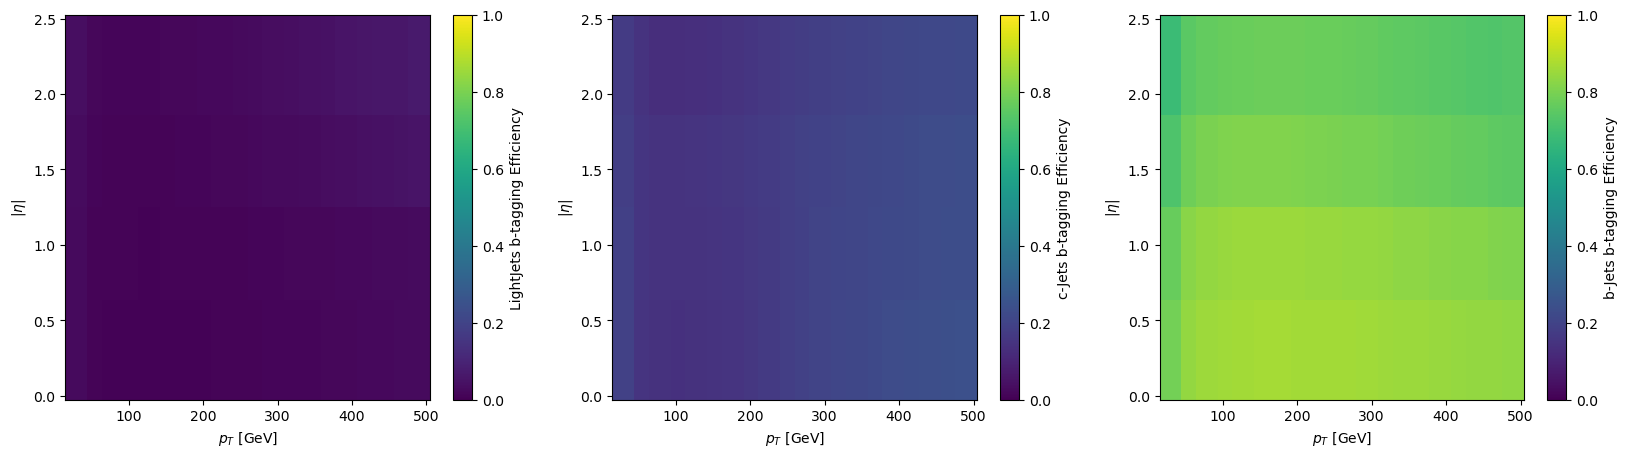

In [29]:
flavor_tags = {0: "LightJets", 4: "c-Jets", 5: "b-Jets"}

pts = np.linspace(20, 500)
etas = np.linspace(0, 2.5)
pt, eta = np.meshgrid(pts, etas)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, flavor in enumerate([0, 4, 5]):
    heatmap = ax[i].pcolormesh(pt, eta, efflookup(pt, eta, flavor), cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(heatmap)
    cbar.set_label(f'{flavor_tags[flavor]} b-tagging Efficiency')
    ax[i].set_xlabel('$p_T$ [GeV]')
    ax[i].set_ylabel('$|\eta|$')

Now, we proceed to save this function

In [16]:
util.save(efflookup, "btag_eff_deepJet_M_2017.coffea")

### Event weight

With the efficiency at hand, we still need to obtain the Scale Factor (SF) factors in order to compute the weights. 

We start by defining a function `get_pog_json` that provides us with the location of the corrections given the name of the correction and the year.

In [17]:
# CorrectionLib files are available from
POG_CORRECTION_PATH = "/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration"

# summary of pog scale factors: https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/
POG_JSONS = {
    "muon": ["MUO", "muon_Z.json.gz"],
    "electron": ["EGM", "electron.json.gz"],
    "pileup": ["LUM", "puWeights.json.gz"],
    "btag": ["BTV", "btagging.json.gz"],
    "met": ["JME", "met.json.gz"],
}

POG_YEARS = {
    "2016": "2016postVFP_UL",
    "2016APV": "2016preVFP_UL",
    "2017": "2017_UL",
    "2018": "2018_UL",
}

def get_pog_json(json_name: str, year: str) -> str:
    """
    returns the path to the pog json file

    Parameters:
    -----------
        json_name:
            json name {'muon', 'electron', 'pileup', 'btag'}
        year:
            dataset year {'2016', '2017', '2018'}
    """
    if json_name in POG_JSONS:
        pog_json = POG_JSONS[json_name]
    else:
        print(f"No json for {json_name}")
    return f"{POG_CORRECTION_PATH}/POG/{pog_json[0]}/{POG_YEARS[year]}/{pog_json[1]}"

Now, we define the `BtagCorrector` class to compute the event weights. The event weights computation (1) is implemented in the `get_btag_weight` method

In [19]:
class BTagCorrector:
    def __init__(
        self,
        sf: str = "comb",
        wp: str = "M",
        tagger: str = "deepJet",
        year: str = "2017",
        mod: str = "",
    ):
        """
        BTag corrector object

        Parameters:
        -----------
            sf:
                scale factors to use (mujets or comb)
            wp:
                worging point {'L', 'M', 'T'}
            tagger:
                tagger {'deepJet', 'deepCSV'}
            year:
                dataset year {'2016', '2017', '2018'}
            mod:
                year modifier {"", "APV"}
        """
        self._sf = sf
        self._year = year + mod
        self._tagger = tagger
        self._wp = wp
        self._branch = TAGGER_BRANCH[tagger]

        # btag working points (only for deepJet)
        # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation
        with importlib.resources.path("wprime_plus_b.data", "btagWPs.json") as path:
            with open(path, "r") as handle:
                btagWPs = json.load(handle)
        self._btagwp = btagWPs[tagger][year + mod][wp]

        # correction set
        self._cset = correctionlib.CorrectionSet.from_file(
            get_pog_json(json_name="btag", year=year + mod)
        )

        # load efficiency 
        # efflookup(pt, |eta|, flavor)
        with importlib.resources.path(
            "wprime_plus_b.data", f"btag_eff_{tagger}_{wp}_{year}.coffea"
        ) as filename:
            self.efflookup = util.load(str(filename))

    def btag_sf(self, j, syst="central"):
        # syst: central, down, down_correlated, down_uncorrelated, up, up_correlated
        j, nj = ak.flatten(j), ak.num(j)
        sf = self._cset[f"{self._tagger}_{self._sf}"].evaluate(
            syst,
            self._wp,
            np.array(j.hadronFlavour),
            np.array(abs(j.eta)),
            np.array(j.pt),
        )
        return ak.unflatten(sf, nj)

    def light_tag_sf(self, j, syst="central"):
        # syst: central, down, down_correlated, down_uncorrelated, up, up_correlated
        j, nj = ak.flatten(j), ak.num(j)
        sf = self._cset["deepJet_incl"].evaluate(
            syst,
            self._wp,
            np.array(j.hadronFlavour),
            np.array(abs(j.eta)),
            np.array(j.pt),
        )
        return ak.unflatten(sf, nj)

    # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BTagSFMethods
    @staticmethod
    def get_btag_weight(eff, sf, passbtag):
        # tagged SF = SF*eff / eff = SF
        tagged_sf = ak.prod(sf[passbtag], axis=-1)
        # untagged SF = (1 - SF*eff) / (1 - eff)
        untagged_sf = ak.prod(((1 - sf * eff) / (1 - eff))[~passbtag], axis=-1)

        return ak.fill_none(tagged_sf * untagged_sf, 1.0)

    def add_btag_weight(self, events: ak.Array, weights: Type[Weights]):
        """
        add b-tagging scale factor

        Parameters:
        -----------
            events:
                Events collection
            weights:
                Weights object from coffea.analysis_tools
        """
        phasespace_cuts = (abs(events.Jet.eta) < 2.5) & (events.Jet.pt > 20.0)

        # hadron flavor definition: 5=b, 4=c, 0=udsg
        bc_jets = events.Jet[phasespace_cuts & (events.Jet.hadronFlavour > 0)]
        light_jets = events.Jet[phasespace_cuts & (events.Jet.hadronFlavour == 0)]

        # efficiencies
        bc_eff = self.efflookup(bc_jets.pt, np.abs(bc_jets.eta), bc_jets.hadronFlavour)
        light_eff = self.efflookup(
            light_jets.pt, np.abs(light_jets.eta), light_jets.hadronFlavour
        )

        # scale factors
        bc_jets_sf = self.btag_sf(bc_jets)
        light_jets_sf = self.light_tag_sf(light_jets)

        # pass btag wp
        bc_pass = bc_jets[self._branch] > self._btagwp
        light_pass = light_jets[self._branch] > self._btagwp

        # get nominal weights
        bc_jets_weight = self.get_btag_weight(bc_eff, bc_jets_sf, bc_pass)
        light_jets_weight = self.get_btag_weight(light_eff, light_jets_sf, light_pass)

        # add nominal weight
        weights.add(name="btag", weight=bc_jets_weight * light_jets_weight)

Now, given some events, we can compute the btag event weights and add them to the `Weights` container using the `add_btag_weight` method:

In [ ]:
weights = Weights(len(events), storeIndividual=True)

if hasattr(events, "genWeight"):
    btag_weight = BTagCorrector(wp="M", tagger="deepJet", year="2017")
    btag_weight.add_btag_weight(events=events, weights=weights)